# Lab 5: World Progress

Welcome to lab 5!  

This final lab in Data 8.1x brings together many of the topics so far, including data table manipulation, visualization, and iteration. The content of the lab is based on a series of talks by Hans Rosling, a statistician who advised many world leaders about the changing state of the world's population. 

(Optional) For a video introduction to the topic of Global population change, you can watch Hans Rosling's video, [Don't Panic: The Facts About Population](https://www.gapminder.org/videos/dont-panic-the-facts-about-population/).

First, set up the tests and imports by running the cell below.

In [2]:
# Run this cell to set up the notebook, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



The global population of humans reached 1 billion around 1800, 3 billion around 1960, and 7 billion around 2011. The potential impact of exponential population growth has concerned scientists, economists, and politicians alike.

The UN Population Division estimates that the world population will likely continue to grow throughout the 21st century, but at a slower rate, perhaps reaching 11 billion by 2100. However, the UN does not rule out scenarios of more extreme growth.

<a href="http://www.pewresearch.org/fact-tank/2015/06/08/scientists-more-worried-than-public-about-worlds-growing-population/ft_15-06-04_popcount/"> 
 <img src="pew_population_projection.png" alt="Estimated and project annual world population from 1950 to 2100.  Estimates in 1950 start at 2 billion and grow to 6 billion in 2000.  Projects say the population in 2100 will be 10.9 billion people."/>
</a>

In this section, we will examine some of the factors that influence population growth and how they are changing around the world.

The first table we will consider is the total population of each country over time. Run the cell below.

In [3]:
# The population.csv file can also be found online here:
# https://github.com/open-numbers/ddf--gapminder--systema_globalis/raw/master/ddf--datapoints--population_total--by--geo--time.csv
# The version in this project was downloaded in February, 2017.
population = Table.read_table('population.csv')
population.show(3)

## 1. Bangladesh

In the `population` table, the `geo` column contains three-letter codes established by the [International Organization for Standardization](https://en.wikipedia.org/wiki/International_Organization_for_Standardization) (ISO) in the [Alpha-3](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3#Current_codes) standard. We will begin by taking a close look at Bangladesh. Inspect the standard to find the 3-letter code for Bangladesh.

**Question 1.1** <br/>Create a table called `b_pop` that has two columns labeled `time` and `population_total`. The first column should contain the years from 1970 through 2015 (including both 1970 and 2015) and the second should contain the population of Bangladesh in each of those years.

In [4]:
b_pop = population.where('geo',are.equal_to('bgd')).where('time',are.between(1970,2016)).drop(0)
b_pop

time | population_total
1970 | 65048701
1971 | 66417450
1972 | 67578486
1973 | 68658472
1974 | 69837960
1975 | 71247153
1976 | 72930206
1977 | 74848466
1978 | 76948378
1979 | 79141947
... (36 rows omitted)

Run the following cell to create a table called `b_five` that has the population of Bangladesh every five years. At a glance, it appears that the population of Bangladesh has been growing quickly indeed!

In [5]:
b_pop.set_format('population_total', NumberFormatter)

fives = np.arange(1970, 2016, 5) # 1970, 1975, 1980, ...
b_five = b_pop.sort('time').where('time', are.contained_in(fives))
b_five

time | population_total
1970 | 65,048,701
1975 | 71,247,153
1980 | 81,364,176
1985 | 93,015,182
1990 | 105,983,136
1995 | 118,427,768
2000 | 131,280,739
2005 | 142,929,979
2010 | 151,616,777
2015 | 160,995,642

Run the next cell to create a table called `b_five_growth` which shows the growth rate for each five-year period from 1970 through 2010.

In [6]:
b_1970_through_2010 = b_five.where('time', are.below_or_equal_to(2010))
b_five_growth = b_1970_through_2010.with_column('annual_growth', (b_five.exclude(0).column(1)/b_1970_through_2010.column(1))**0.2-1)
b_five_growth.set_format('annual_growth', PercentFormatter)

time | population_total | annual_growth
1970 | 65,048,701       | 1.84%
1975 | 71,247,153       | 2.69%
1980 | 81,364,176       | 2.71%
1985 | 93,015,182       | 2.64%
1990 | 105,983,136      | 2.25%
1995 | 118,427,768      | 2.08%
2000 | 131,280,739      | 1.71%
2005 | 142,929,979      | 1.19%
2010 | 151,616,777      | 1.21%

While the population has grown every five years since 1970, the annual growth rate decreased dramatically from 1985 to 2005. Let's look at some other information in order to develop a possible explanation. Run the next cell to load three additional tables of measurements about countries over time.

In [7]:
life_expectancy = Table.read_table('life_expectancy.csv')
child_mortality = Table.read_table('child_mortality.csv').relabeled(2, 'child_mortality_under_5_per_1000_born')
fertility = Table.read_table('fertility.csv')

The `life_expectancy` table contains a statistic that is often used to measure how long people live, called *life expectancy at birth*. This number, for a country in a given year, [does not measure how long babies born in that year are expected to live](http://blogs.worldbank.org/opendata/what-does-life-expectancy-birth-really-mean). Instead, it measures how long someone would live, on average, if the *mortality conditions* in that year persisted throughout their lifetime. These "mortality conditions" describe what fraction of people at each age survived the year. So, it is a way of measuring the proportion of people that are staying alive, aggregated over different age groups in the population.

The `fertility` table contains a statistic that is often used to measure how many babies are being born, the *total fertility rate*. This number describes the [number of children a woman would have in her lifetime](https://www.measureevaluation.org/prh/rh_indicators/specific/fertility/total-fertility-rate), on average, if the current rates of birth by age of the mother persisted throughout her child bearing years, assuming she survived through age 49. 

**Question 1.2.** <br/>Write a function `fertility_over_time` that takes the Alpha-3 code of a `country` and a `start` year. It returns a two-column table with labels "`Year`" and "`Children per woman`" that can be used to generate a line chart of the country's fertility rate each year, starting at the `start` year. The plot should include the `start` year and all later years that appear in the `fertility` table. 

Then, in the next cell, call your `fertility_over_time` function on the Alpha-3 code for Bangladesh and the year 1970 in order to plot how Bangladesh's fertility rate has changed since 1970. Note that the function `fertility_over_time` should not return the plot itself **The expression that draws the line plot is provided for you; please don't change it.**

In [8]:
def fertility_over_time(country, start):
    """Create a two-column table that describes a country's total fertility rate each year."""
    country_fertility = fertility.where('geo',are.equal_to(country)).where('time',are.above(start-1))
    country_fertility_after_start = country_fertility.drop(0).relabeled(0,'Year').relabeled(1,'Children per woman')
    return(country_fertility_after_start)

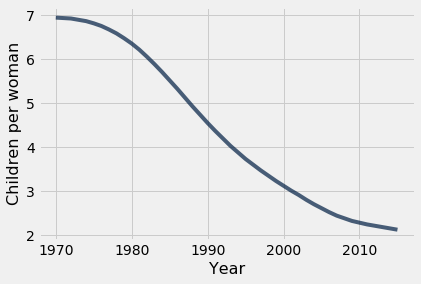

In [9]:
bangladesh_code = 'bgd'
fertility_over_time(bangladesh_code, 1970).plot(0, 1) # You should *not* change this line.

**Question 1.3.** <br/>Using both the `fertility` and `child_mortality` tables, draw a scatter diagram with one point for each year, starting with 1970, that has Bangladesh's total fertility on the horizontal axis and its child mortality on the vertical axis. 

**The expression that draws the scatter diagram is provided for you; please don't change it.** Instead, create a table called `post_1969_fertility_and_child_mortality` with the appropriate column labels and data in order to generate the chart correctly. Use the label "`Children per woman`" to describe total fertility and the label "`Child deaths per 1000 born`" to describe child mortality.

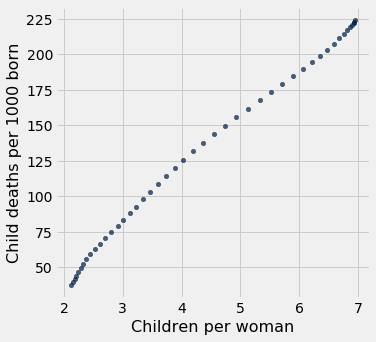

In [10]:
bgd_fertility = fertility_over_time('bgd',1970)
bgd_child_mortality = child_mortality.where('geo',are.equal_to('bgd')).where('time',are.above(1969)).drop(0).relabeled(1,'Child deaths per 1000 born')
fertility_and_child_mortality = bgd_fertility.join('Year',bgd_child_mortality,'time')
post_1969_fertility_and_child_mortality = fertility_and_child_mortality
post_1969_fertility_and_child_mortality.scatter('Children per woman', 'Child deaths per 1000 born') # You should *not* change this line.

## 2. The World

The change observed in Bangladesh since 1970 can also be observed in many other developing countries: health services improve, life expectancy increases, and child mortality decreases. At the same time, the fertility rate often plummets, and so the population growth rate decreases despite increasing longevity.

Run the next cell to see a line plot of the world population from 1800 through 2005.  You might recognize some of the code used!

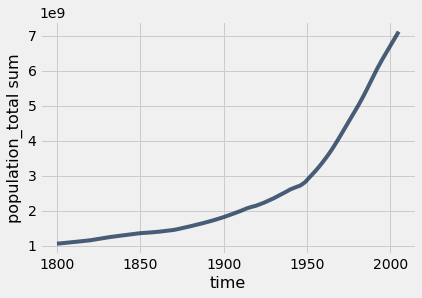

In [12]:
population = population.with_column('pop64',np.float64(population.column('population_total'))).drop(2).relabeled(2,'population_total')
population.where('time', are.between(1800, 2006)).drop('geo').group('time', sum).plot(0)

**Question 2.1.** Create a function `stats_for_year` that takes a `year` and returns a table of statistics. The table it returns should have four columns: `geo`, `population_total`, `children_per_woman_total_fertility`, and `child_mortality_under_5_per_1000_born`. Each row should contain one Alpha-3 country code and three statistics: population, fertility rate, and child mortality for that `year` from the `population`, `fertility` and `child_mortality` tables. Only include rows for which all three statistics are available for the country and year.

In addition, restrict the result to country codes that appears in `big_50`, an array of the 50 most populous countries in 2010. This restriction will speed up computations later in the project.

*Hint*: The tests for this question are quite comprehensive, so if you pass the tests, your function is probably correct. However, without calling your function yourself and looking at the output, it will be very difficult to understand any problems you have, so try your best to write the function correctly and check that it works before you rely on the `ok` tests to confirm your work.

In [13]:
# We first create a population table that only includes the 
# 50 countries with the largest 2010 populations. We focus on 
# these 50 countries only so that plotting later will run faster.
big_50 = population.where('time', 2010).sort(2, descending=True).take(np.arange(50)).column('geo')
population_of_big_50 = population.where('time', are.above(1959)).where('geo', are.contained_in(big_50))

def stats_for_year(year):
    """Return a table of the stats for each country that year."""
    p = population_of_big_50.where('time', year).drop('time')
    f = fertility.where('time', year).drop('time')
    c = child_mortality.where('time', year).drop('time')
    statistics_table = p.join('geo',f).join('geo',c)
    return(statistics_table)

Try calling your function `stats_for_year` on any year between 1960 and 2010 in the cell below.  Try to understand the output of `stats_for_year`.

In [14]:
stats_for_year(1967)

geo  | population_total | children_per_woman_total_fertility | child_mortality_under_5_per_1000_born
afg  | 1.03686e+07      | 7.67                               | 323.3
arg  | 2.29322e+07      | 3.05                               | 58.52
bgd  | 5.96253e+07      | 6.92                               | 229.4
bra  | 8.88537e+07      | 5.49                               | 143.9
can  | 2.03894e+07      | 2.6                                | 25
chn  | 7.44366e+08      | 5.25                               | 126.4
cod  | 1.83782e+07      | 6.14                               | 254.8
col  | 2.03114e+07      | 6.25                               | 108
deu  | 7.71069e+07      | 2.37                               | 29.31
dza  | 1.33542e+07      | 7.66                               | 248.9
... (40 rows omitted)

**Question 2.2.** <br/>Create a table called `pop_by_decade` with two columns called `decade` and `population`. It has a row for each `year` since 1960 that starts a decade. The `population` column contains the total population of all countries included in the result of `stats_for_year(year)` for the first `year` of the decade. For example, 1960 is the first year of the 1960's decade. You should see that these countries contain most of the world's population.

*Hint:* It may be helpful to use the provided `pop_for_year` that computes this total population, then `apply` it to the `decade` column.

In [15]:
def pop_for_year(year):
    return sum(stats_for_year(year).column('population_total'))

In [16]:
decades = Table().with_column('decade', np.arange(1960, 2011, 10))

pop_by_decade = decades.with_column('population',decades.apply(pop_for_year))
pop_by_decade.set_format(1, NumberFormatter)
pop_by_decade

decade | population
1960   | 2,624,944,597.00
1970   | 3,211,487,418.00
1980   | 3,880,722,003.00
1990   | 4,648,434,558.00
2000   | 5,367,553,063.00
2010   | 6,040,810,517.00

The `countries` table describes various characteristics of countries. The `country` column contains the same codes as the `geo` column in each of the other data tables (`population`, `fertility`, and `child_mortality`). The `world_6region` column classifies each country into a region of the world. Run the cell below to inspect the data.

In [17]:
countries = Table.read_table('countries.csv').where('country', are.contained_in(population.group('geo').column(0)))
countries = countries.select('country', 'name', 'world_6region')

**Question 2.3.** <br/>Create a table called `region_counts` that has two columns, `region` and `count`. It should describe the count of how many countries in each region appear in the result of `stats_for_year(1960)`. For example, one row would have `south_asia` as its `world_6region` value and an integer as its `count` value: the number of large South Asian countries for which we have population, fertility, and child mortality numbers from 1960.

In [18]:
region_counts = stats_for_year(1960).join('geo',countries,'country').select(0,5).group(1).relabeled(0,'region')
region_counts

region                   | count
america                  | 8
east_asia_pacific        | 10
europe_central_asia      | 10
middle_east_north_africa | 7
south_asia               | 5
sub_saharan_africa       | 10

The following scatter diagram compares total fertility rate and child mortality rate for each country in 1960. The area of each dot represents the population of the country, and the color represents its region of the world. Run the cell. Do you think you can identify any of the dots?

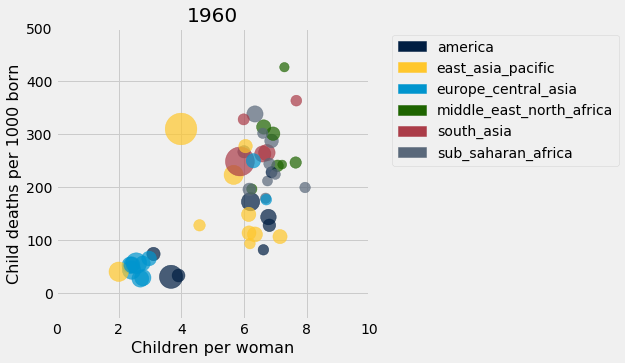

In [19]:
from functools import lru_cache as cache

# This cache annotation makes sure that if the same year
# is passed as an argument twice, the work of computing
# the result is only carried out once and then saved.
@cache(None)
def stats_relabeled(year):
    """Relabeled and cached version of stats_for_year."""
    return stats_for_year(year).relabeled(2, 'Children per woman').relabeled(3, 'Child deaths per 1000 born')

def fertility_vs_child_mortality(year):
    """Draw a color scatter diagram comparing child mortality and fertility."""
    with_region = stats_relabeled(year).join('geo', countries.select('country', 'world_6region'), 'country')
    with_region.scatter(2, 3, sizes=1, colors=4, s=500)
    plots.xlim(0,10)
    plots.ylim(-50, 500)
    plots.title(year)

fertility_vs_child_mortality(1960)

The result of the cell below is interactive. It may take several minutes to run because it computers 55 tables (one for each year). When it's done, a scatter plot and a slider should appear.

Drag the slider to the right to see how countries have changed over time. You'll find that the great divide between so-called "Western" and "developing" countries that existed in the 1960's has nearly disappeared. This shift in fertility rates is the reason that the global population is expected to grow more slowly in the 21st century than it did in the 19th and 20th centuries.

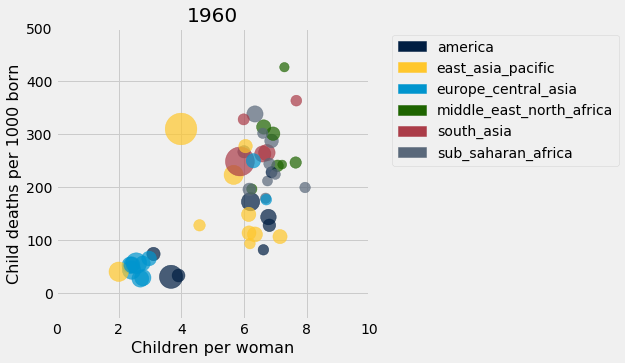

In [20]:
import ipywidgets as widgets

# This part takes a few minutes to run because it 
# computes 55 tables in advance: one for each year.
for year in np.arange(1960, 2016):
    stats_relabeled(year)

_ = widgets.interact(fertility_vs_child_mortality, 
                     year=widgets.IntSlider(min=1960, max=2015, value=1960))

## Submission

Congratulations, you're done with lab 5 and Data 8.1x!  Be sure to 
- **run all the tests and verify that they all pass** (the next cell has a shortcut for that), 
- **Review the notebook one last time, we will be grading the final state of your notebook after the deadline**,
- **Save and Checkpoint** from the `File` menu,

Now is a great time to watch the same data presented by [Hans Rosling in a 2010 TEDx talk](https://www.gapminder.org/videos/reducing-child-mortality-a-moral-and-environmental-imperative) with smoother animation and witty commentary.

**Congratulations on finishing Data 8.1X!**